# Wifind Data - Final Analysis 

## Author_: Chritstian Rosado

In [1801]:
# importing packages 
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fiona.crs import from_epsg
import shapely as shp
import seaborn 
import os
import geopandas as gpd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Applications/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Polygon', 'chisquare', 'axes', 'colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [1802]:
# important all data
startdate = "06/01/2017"
enddate = "07/23/2017"
link = 'http://wifindproject.com/wifipulling/?columns=lat%7Clng%7Cssid%7Cbssid%7Cacc%7Ctime%7Clevel\
&startdate={0}&enddate={1}&timeformat=1'.format(startdate,enddate)
print(link)

http://wifindproject.com/wifipulling/?columns=lat%7Clng%7Cssid%7Cbssid%7Cacc%7Ctime%7Clevel&startdate=06/01/2017&enddate=07/23/2017&timeformat=1


In [1803]:
# loading raw data for analysis 
data = pd.read_json(link, dtype={"lng":float, "lat":float})

In [1804]:
data.shape

(1300700, 7)

In [1805]:
# filtering errant scans 
wifi_data = data.drop(data[data.acc > 50].index)

In [1806]:
wifi_data.head(1)

,acc,bssid,lat,level,lng,ssid,time
0,19.929,fc:0a:81:c0:b4:b2,40.710426,-54.0,-74.011387,,06-12-2017 15:51:03


In [1808]:
wifi_data.shape

(1248783, 7)

In [1809]:
# errant resords removed
errant_records = data.shape[0] - wifi_data.shape[0]
print("number of errant records removed:", errant_records)

number of errant records removed: 51917


In [1810]:
wifi_data.to_csv("wifi_data.csv")

In [1811]:
wifi_data[["acc", "level"]].describe()

,acc,level
count,1.248783e+06,1.248783e+06
mean,1.407823e+01,-7.777126e+01
std,8.515134e+00,1.006214e+01
min,3.000000e+00,-9.900000e+01
25%,9.000000e+00,-8.600000e+01
50%,1.100000e+01,-7.900000e+01
75%,1.820400e+01,-7.100000e+01
max,5.000000e+01,-1.000000e+01


In [1812]:
# generating points for wifi data
def points(p):
    point = shp.geometry.Point(p)
    return point

wifi_data["geometry"] = list(map(lambda x: points(x), zip(wifi_data.lng, wifi_data.lat)))

In [1813]:
wifi_data.head(1)

,acc,bssid,lat,level,lng,ssid,time,geometry
0,19.929,fc:0a:81:c0:b4:b2,40.710426,-54.0,-74.011387,,06-12-2017 15:51:03,POINT (-74.01138659999999 40.7104258)


In [1814]:
wifi_data.shape

(1248783, 8)

In [1815]:
# loading wifi data into geopandas
wifi_shape = gpd.GeoDataFrame(wifi_data)

In [1817]:
#housing_shape = gpd.GeoDataFrame.from_file("../Downloads/data/shape/Export_Output.shp")

In [1816]:
# loading census block groups shapes into geopandas
housing_shape = gpd.GeoDataFrame.from_file("../Downloads/data/tl_2013_36_bg/tl_2013_36_bg.shp")

In [1818]:
housing_shape.shape

(15463, 13)

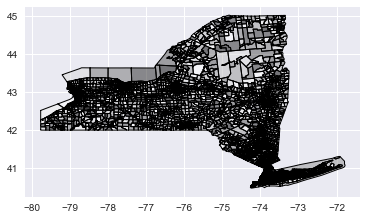

In [112]:
housing_shape.plot()

In [1820]:
# epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
wifi_shape.crs = from_epsg(4326)
housing_shape.crs = from_epsg(4326)

In [1822]:
# merging wifi data with housing shapes - blocks 
# geometry = points
housing_wifi = gpd.sjoin(wifi_shape, housing_shape, how="inner", op='intersects') #geo merger

In [1825]:
# merging wifi data with housing shapes - blocks 
# geometry = polygons
housing_wifi_ = gpd.sjoin(housing_shape, wifi_shape, how="inner", op='intersects') #geo merger

In [1826]:
housing_shape.shape

(15463, 13)

In [1827]:
housing_wifi_.head(1)

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,...,TRACTCE,geometry,index_right,acc,bssid,lat,level,lng,ssid,time
1942,89832,0,1,061,S,360610015011,+40.7107881,-074.0060113,G5030,Block Group 1,...,001501,"POLYGON ((-74.00861399999999 40.711372, -74.00...",881088,50.0,fc:0a:81:b5:ee:c2,40.710642,-77.0,-74.008483,,07-10-2017 19:47:26


In [1829]:
uni_bssid = housing_wifi_.groupby(housing_wifi_.GEOID)['bssid'].nunique()

In [1830]:
uni_bssid = pd.DataFrame(uni_bssid)

In [1831]:
uni_bssid["GEOID"] = uni_bssid.index
uni_bssid["uni_bssid_count"] = uni_bssid.bssid

In [1833]:
del uni_bssid["bssid"]

In [1834]:
uni_bssid.head()

,GEOID,uni_bssid_count
GEOID,,
360470001004,360470001004,9
360470003014,360470003014,306
360470005013,360470005013,251
360470005022,360470005022,214
360470007001,360470007001,562


In [1835]:
# merge unique bssid with main data frame
housing_wifi__uni = housing_wifi_.merge(uni_bssid, on="GEOID", how="inner")

In [1836]:
housing_wifi__uni.head(1)

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,...,geometry,index_right,acc,bssid,lat,level,lng,ssid,time,uni_bssid_count
0,89832,0,1,061,S,360610015011,+40.7107881,-074.0060113,G5030,Block Group 1,...,"POLYGON ((-74.00861399999999 40.711372, -74.00...",881088,50.0,fc:0a:81:b5:ee:c2,40.710642,-77.0,-74.008483,,07-10-2017 19:47:26,24


In [1837]:
housing_wifi__uni.shape

(1243976, 22)

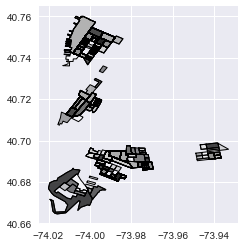

In [1840]:
housing_wifi__uni[::1000].plot()

In [1842]:
# Merge Population and median household income Data for blocks groups

In [1841]:
# genrate bar chart, t-test, and plot median household income vs. bssid/population

# Loading Demographic Data - Population, MHI, and Education (if possible)

# Income

In [1042]:
# merge income data

In [1843]:
census_block_group_income = pd.read_csv("../Downloads/data/census_block_group_income.csv", converters={"Geo_FIPS":str})

In [1844]:
census_block_group_income["GEOID"] = census_block_group_income.Geo_FIPS
del census_block_group_income["Geo_FIPS"]
census_block_group_income["MHI"] = census_block_group_income.SE_T093_001
del census_block_group_income["SE_T093_001"]

In [1845]:
census_block_group_income.head(1)

,Geo_NAME,Geo_QName,Geo_AREALAND,Geo_AREAWATR,Geo_SUMLEV,Geo_GEOCOMP,Geo_REGION,Geo_DIVISION,Geo_STATE,Geo_COUNTY,Geo_TRACT,Geo_BLKGRP,GEOID,MHI
0,Block Group 1,"Block Group 1, Census Tract 1, Albany County, ...",2005713,235376,150,0,1,2,36,1,100,1,360010001001,24615


In [1847]:
census_block_group_income.shape

(15079, 14)

In [1107]:
#census_block_group_income["block_group"], census_block_group_income["census_tract"], \
#census_block_group_income["county"], census_block_group_income["state"] = \
#census_block_group_income.Geo_QName.str.split(',').str

In [1108]:
#census_block_group_income["block_group"] = census_block_group_income["block_group"].str.split(' ').str[2]
#census_block_group_income["block_group"] = 

In [1109]:
#census_block_group_income["census_tract"] = census_block_group_income["census_tract"].str.split(' ').str[3]
#census_block_group_income["census_tract"] =

In [1110]:
#census_block_group_income[census_block_group_income.county.str.contains("Richmond County")]

In [1848]:
housing_wifi__uni.GEOID.dtype

dtype('O')

In [1849]:
census_block_group_income.GEOID.dtype

dtype('O')

In [1850]:
housing_wifi_uni_by_bl_group = housing_wifi__uni.merge(census_block_group_income, on="GEOID", how="inner")

In [1851]:
housing_wifi_uni_by_bl_group.shape

(1074051, 35)

In [1852]:
housing_wifi_uni_by_bl_group.head()

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,...,Geo_AREAWATR,Geo_SUMLEV,Geo_GEOCOMP,Geo_REGION,Geo_DIVISION,Geo_STATE,Geo_COUNTY,Geo_TRACT,Geo_BLKGRP,MHI
0,89832,0,1,061,S,360610015011,+40.7107881,-074.0060113,G5030,Block Group 1,...,0,150,0,1,2,36,61,1501,1,37232
1,89832,0,1,061,S,360610015011,+40.7107881,-074.0060113,G5030,Block Group 1,...,0,150,0,1,2,36,61,1501,1,37232
2,89832,0,1,061,S,360610015011,+40.7107881,-074.0060113,G5030,Block Group 1,...,0,150,0,1,2,36,61,1501,1,37232
3,89832,0,1,061,S,360610015011,+40.7107881,-074.0060113,G5030,Block Group 1,...,0,150,0,1,2,36,61,1501,1,37232
4,89832,0,1,061,S,360610015011,+40.7107881,-074.0060113,G5030,Block Group 1,...,0,150,0,1,2,36,61,1501,1,37232


In [1853]:
housing_wifi_uni_by_bl_group.columns

Index(['ALAND', 'AWATER', 'BLKGRPCE', 'COUNTYFP', 'FUNCSTAT', 'GEOID',
       'INTPTLAT', 'INTPTLON', 'MTFCC', 'NAMELSAD', 'STATEFP', 'TRACTCE',
       'geometry', 'index_right', 'acc', 'bssid', 'lat', 'level', 'lng',
       'ssid', 'time', 'uni_bssid_count', 'Geo_NAME', 'Geo_QName',
       'Geo_AREALAND', 'Geo_AREAWATR', 'Geo_SUMLEV', 'Geo_GEOCOMP',
       'Geo_REGION', 'Geo_DIVISION', 'Geo_STATE', 'Geo_COUNTY', 'Geo_TRACT',
       'Geo_BLKGRP', 'MHI'],
      dtype='object')

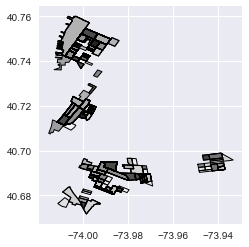

In [1854]:
housing_wifi_uni_by_bl_group[::1000].plot()

# Population

In [1855]:
# merge population 

In [1856]:
# Loading population data by block group
census_block_group_pop = pd.read_csv("../Downloads/data/census_block_group_pop.csv", converters={"Geo_FIPS":str})

In [1857]:
census_block_group_pop["GEOID"] = census_block_group_pop.Geo_FIPS
del census_block_group_pop["Geo_FIPS"]
census_block_group_pop["Population"] = census_block_group_pop.SE_T003_002
del census_block_group_pop["SE_T003_002"]
census_block_group_pop["Pop_Density"] = census_block_group_pop.SE_T003_001
del census_block_group_pop["SE_T003_001"]

In [1858]:
census_block_group_pop.head(1)

,Geo_NAME,Geo_QName,Geo_AREALAND,Geo_AREAWATR,Geo_SUMLEV,Geo_GEOCOMP,Geo_REGION,Geo_DIVISION,Geo_STATE,Geo_COUNTY,Geo_TRACT,Geo_BLKGRP,SE_T003_003,GEOID,Population,Pop_Density
0,Block Group 1,"Block Group 1, Census Tract 1, Albany County, ...",2005713,235376,150,0,1,2,36,1,100,1,0.77441,360010001001,1031,1331.336


In [1859]:
housing_wifi_uni_by_bl_group.GEOID.dtype

dtype('O')

In [1860]:
census_block_group_pop.GEOID.dtype

dtype('O')

In [1861]:
housing_wifi_uni_by_bl_group_ = housing_wifi_uni_by_bl_group.merge(census_block_group_pop, on="GEOID", how="inner")

In [1862]:
housing_wifi_uni_by_bl_group_.shape

(1074051, 50)

In [1863]:
housing_wifi_uni_by_bl_group_.head(1)

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,...,Geo_GEOCOMP_y,Geo_REGION_y,Geo_DIVISION_y,Geo_STATE_y,Geo_COUNTY_y,Geo_TRACT_y,Geo_BLKGRP_y,SE_T003_003,Population,Pop_Density
0,89832,0,1,061,S,360610015011,+40.7107881,-074.0060113,G5030,Block Group 1,...,0,1,2,36,61,1501,1,0.040587,3552,87515.58


In [1864]:
housing_wifi_uni_by_bl_group_.columns

Index(['ALAND', 'AWATER', 'BLKGRPCE', 'COUNTYFP', 'FUNCSTAT', 'GEOID',
       'INTPTLAT', 'INTPTLON', 'MTFCC', 'NAMELSAD', 'STATEFP', 'TRACTCE',
       'geometry', 'index_right', 'acc', 'bssid', 'lat', 'level', 'lng',
       'ssid', 'time', 'uni_bssid_count', 'Geo_NAME_x', 'Geo_QName_x',
       'Geo_AREALAND_x', 'Geo_AREAWATR_x', 'Geo_SUMLEV_x', 'Geo_GEOCOMP_x',
       'Geo_REGION_x', 'Geo_DIVISION_x', 'Geo_STATE_x', 'Geo_COUNTY_x',
       'Geo_TRACT_x', 'Geo_BLKGRP_x', 'MHI', 'Geo_NAME_y', 'Geo_QName_y',
       'Geo_AREALAND_y', 'Geo_AREAWATR_y', 'Geo_SUMLEV_y', 'Geo_GEOCOMP_y',
       'Geo_REGION_y', 'Geo_DIVISION_y', 'Geo_STATE_y', 'Geo_COUNTY_y',
       'Geo_TRACT_y', 'Geo_BLKGRP_y', 'SE_T003_003', 'Population',
       'Pop_Density'],
      dtype='object')

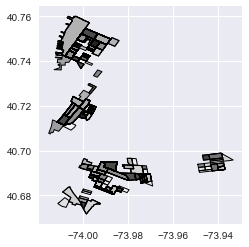

In [1865]:
housing_wifi_uni_by_bl_group_[::1000].plot()

# Education

In [1866]:
# merge education

In [1867]:
# Loading education data by block group
census_block_group_edu = pd.read_csv("../Downloads/data/education_attainment.csv", converters={"Geo_FIPS":str})

In [1868]:
census_block_group_edu["GEOID"] = census_block_group_edu.Geo_FIPS
del census_block_group_edu["Geo_FIPS"]
census_block_group_edu["Pop_over_25"] = census_block_group_edu.SE_T040_001
del census_block_group_edu["SE_T040_001"]
census_block_group_edu["Less_than_HS"] = census_block_group_edu.SE_T040_002
del census_block_group_edu["SE_T040_002"]
census_block_group_edu["High_School"] = census_block_group_edu.SE_T040_003
del census_block_group_edu["SE_T040_003"]
census_block_group_edu["Some_College"] = census_block_group_edu.SE_T040_004
del census_block_group_edu["SE_T040_004"]
census_block_group_edu["Bachelors"] = census_block_group_edu.SE_T040_005
del census_block_group_edu["SE_T040_005"]
census_block_group_edu["Masters"] = census_block_group_edu.SE_T040_006
del census_block_group_edu["SE_T040_006"]
census_block_group_edu["Professional_School_Degree"] = census_block_group_edu.SE_T040_007
del census_block_group_edu["SE_T040_007"]
census_block_group_edu["Doctorate"] = census_block_group_edu.SE_T040_008
del census_block_group_edu["SE_T040_008"]

In [1869]:
census_block_group_edu.head(1)

,Geo_NAME,Geo_QName,Geo_AREALAND,Geo_AREAWATR,Geo_SUMLEV,Geo_GEOCOMP,Geo_REGION,Geo_DIVISION,Geo_STATE,Geo_COUNTY,...,Geo_BLKGRP,GEOID,Pop_over_25,Less_than_HS,High_School,Some_College,Bachelors,Masters,Professional_School_Degree,Doctorate
0,Block Group 1,"Block Group 1, Census Tract 1, Albany County, ...",2005713,235376,150,0,1,2,36,1,...,1,360010001001,685,198,181,222,62,15,7,0


In [1870]:
housing_wifi_uni_by_bl_group_.GEOID.dtype

dtype('O')

In [1871]:
census_block_group_edu.GEOID.dtype

dtype('O')

In [1872]:
housing_wifi_uni_by_bl_group__ = housing_wifi_uni_by_bl_group_.merge(census_block_group_edu, on="GEOID", how="inner")

In [1873]:
housing_wifi_uni_by_bl_group__.shape

(1074051, 70)

In [1874]:
housing_wifi_uni_by_bl_group__.head(1)

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,...,Geo_TRACT,Geo_BLKGRP,Pop_over_25,Less_than_HS,High_School,Some_College,Bachelors,Masters,Professional_School_Degree,Doctorate
0,89832,0,1,061,S,360610015011,+40.7107881,-074.0060113,G5030,Block Group 1,...,1501,1,3032,408,709,730,830,238,97,20


In [1876]:
housing_wifi_uni_by_bl_group__.columns

Index(['ALAND', 'AWATER', 'BLKGRPCE', 'COUNTYFP', 'FUNCSTAT', 'GEOID',
       'INTPTLAT', 'INTPTLON', 'MTFCC', 'NAMELSAD', 'STATEFP', 'TRACTCE',
       'geometry', 'index_right', 'acc', 'bssid', 'lat', 'level', 'lng',
       'ssid', 'time', 'uni_bssid_count', 'Geo_NAME_x', 'Geo_QName_x',
       'Geo_AREALAND_x', 'Geo_AREAWATR_x', 'Geo_SUMLEV_x', 'Geo_GEOCOMP_x',
       'Geo_REGION_x', 'Geo_DIVISION_x', 'Geo_STATE_x', 'Geo_COUNTY_x',
       'Geo_TRACT_x', 'Geo_BLKGRP_x', 'MHI', 'Geo_NAME_y', 'Geo_QName_y',
       'Geo_AREALAND_y', 'Geo_AREAWATR_y', 'Geo_SUMLEV_y', 'Geo_GEOCOMP_y',
       'Geo_REGION_y', 'Geo_DIVISION_y', 'Geo_STATE_y', 'Geo_COUNTY_y',
       'Geo_TRACT_y', 'Geo_BLKGRP_y', 'SE_T003_003', 'Population',
       'Pop_Density', 'Geo_NAME', 'Geo_QName', 'Geo_AREALAND', 'Geo_AREAWATR',
       'Geo_SUMLEV', 'Geo_GEOCOMP', 'Geo_REGION', 'Geo_DIVISION', 'Geo_STATE',
       'Geo_COUNTY', 'Geo_TRACT', 'Geo_BLKGRP', 'Pop_over_25', 'Less_than_HS',
       'High_School', 'Some_College',

In [1877]:
del housing_wifi_uni_by_bl_group__["index_right"]

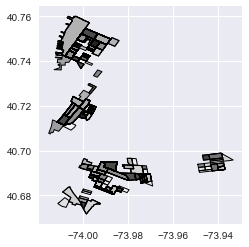

In [1878]:
housing_wifi_uni_by_bl_group__[::1000].plot()

# Loading 10 Areas

In [1882]:
# loading housing projects areas shapes into geopandas (10)
housing_areas_shape = gpd.GeoDataFrame.from_file("../Downloads/data/Ranges_new/Ranges.shp")

In [1883]:
housing_areas_shape.head(1)

,cartodb_id,descriptio,geometry,name
0,8,,"POLYGON ((-74.00246859000001 40.6730546, -74.0...",Public_RedHook


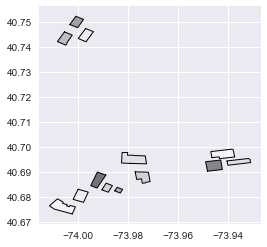

In [1884]:
housing_areas_shape.plot()

In [1885]:
housing_areas_shape.crs = from_epsg(4326)

In [1886]:
housing_gdf = gpd.sjoin(housing_wifi_uni_by_bl_group__, housing_areas_shape, how="inner", op='within')

In [1887]:
# 422365
housing_gdf.shape

(447385, 73)

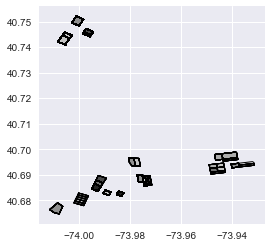

In [1889]:
housing_gdf[::100].plot()

In [1890]:
housing_gdf.columns

Index(['ALAND', 'AWATER', 'BLKGRPCE', 'COUNTYFP', 'FUNCSTAT', 'GEOID',
       'INTPTLAT', 'INTPTLON', 'MTFCC', 'NAMELSAD', 'STATEFP', 'TRACTCE',
       'geometry', 'acc', 'bssid', 'lat', 'level', 'lng', 'ssid', 'time',
       'uni_bssid_count', 'Geo_NAME_x', 'Geo_QName_x', 'Geo_AREALAND_x',
       'Geo_AREAWATR_x', 'Geo_SUMLEV_x', 'Geo_GEOCOMP_x', 'Geo_REGION_x',
       'Geo_DIVISION_x', 'Geo_STATE_x', 'Geo_COUNTY_x', 'Geo_TRACT_x',
       'Geo_BLKGRP_x', 'MHI', 'Geo_NAME_y', 'Geo_QName_y', 'Geo_AREALAND_y',
       'Geo_AREAWATR_y', 'Geo_SUMLEV_y', 'Geo_GEOCOMP_y', 'Geo_REGION_y',
       'Geo_DIVISION_y', 'Geo_STATE_y', 'Geo_COUNTY_y', 'Geo_TRACT_y',
       'Geo_BLKGRP_y', 'SE_T003_003', 'Population', 'Pop_Density', 'Geo_NAME',
       'Geo_QName', 'Geo_AREALAND', 'Geo_AREAWATR', 'Geo_SUMLEV',
       'Geo_GEOCOMP', 'Geo_REGION', 'Geo_DIVISION', 'Geo_STATE', 'Geo_COUNTY',
       'Geo_TRACT', 'Geo_BLKGRP', 'Pop_over_25', 'Less_than_HS', 'High_School',
       'Some_College', 'Bachelors', '

In [1891]:
pd.DataFrame(housing_gdf.name.unique(), columns=["Areas"])

,Areas
0,Public_RedHook
1,Non_Public_RedHook
2,Public_Whitman
3,Public_Gowanus
4,Public_Chelsea
5,Non_Public_Tompkins
6,Non_Public_Gowanus
7,Public_Tompkins
8,Non_Public_Chelsea
9,Non_Public_Whitman


In [1892]:
housing_gdf.head()

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,...,High_School,Some_College,Bachelors,Masters,Professional_School_Degree,Doctorate,index_right,cartodb_id,descriptio,name
947524,114476,0,1,047,S,360470085001,+40.6766988,-074.0086120,G5030,Block Group 1,...,947,649,79,50,0,0,0,8,,Public_RedHook
947525,114476,0,1,047,S,360470085001,+40.6766988,-074.0086120,G5030,Block Group 1,...,947,649,79,50,0,0,0,8,,Public_RedHook
947526,114476,0,1,047,S,360470085001,+40.6766988,-074.0086120,G5030,Block Group 1,...,947,649,79,50,0,0,0,8,,Public_RedHook
947527,114476,0,1,047,S,360470085001,+40.6766988,-074.0086120,G5030,Block Group 1,...,947,649,79,50,0,0,0,8,,Public_RedHook
947528,114476,0,1,047,S,360470085001,+40.6766988,-074.0086120,G5030,Block Group 1,...,947,649,79,50,0,0,0,8,,Public_RedHook


# Delete This Later...

In [1909]:
area_populations = housing_gdf.groupby(["name"])["Population"].unique()

In [1910]:
area_populations = pd.DataFrame(area_populations)

In [1911]:
area_populations

,Population
name,
Non_Public_Chelsea,"[1723, 911]"
Non_Public_Gowanus,"[848, 733, 825]"
Non_Public_RedHook,"[761, 729, 692, 625, 570]"
Non_Public_Tompkins,"[1091, 584, 613, 1026, 1131]"
Non_Public_Whitman,"[780, 853, 410, 571]"
Public_Chelsea,"[1546, 1479, 1260]"
Public_Gowanus,"[3221, 957]"
Public_RedHook,[7278]
Public_Tompkins,"[3595, 2921, 1641, 1135, 1305, 1600]"


In [1912]:
area_populations["Population"] = list(map(lambda x: x[0].sum(),area_populations.Population))

In [1913]:
area_populations

,Population
name,
Non_Public_Chelsea,1723
Non_Public_Gowanus,848
Non_Public_RedHook,761
Non_Public_Tompkins,1091
Non_Public_Whitman,780
Public_Chelsea,1546
Public_Gowanus,3221
Public_RedHook,7278
Public_Tompkins,3595


In [1914]:
area_populations["name"] = area_populations.index

In [1915]:
#area_populations = housing_gdf.groupby(["name","GEOID"])["Population"].unique()

In [1916]:
area_populations

,Population,name
name,,
Non_Public_Chelsea,1723,Non_Public_Chelsea
Non_Public_Gowanus,848,Non_Public_Gowanus
Non_Public_RedHook,761,Non_Public_RedHook
Non_Public_Tompkins,1091,Non_Public_Tompkins
Non_Public_Whitman,780,Non_Public_Whitman
Public_Chelsea,1546,Public_Chelsea
Public_Gowanus,3221,Public_Gowanus
Public_RedHook,7278,Public_RedHook
Public_Tompkins,3595,Public_Tompkins


In [1917]:
area_populations.shape

(10, 2)

In [1918]:
housing_gdf.columns

Index(['ALAND', 'AWATER', 'BLKGRPCE', 'COUNTYFP', 'FUNCSTAT', 'GEOID',
       'INTPTLAT', 'INTPTLON', 'MTFCC', 'NAMELSAD', 'STATEFP', 'TRACTCE',
       'geometry', 'acc', 'bssid', 'lat', 'level', 'lng', 'ssid', 'time',
       'uni_bssid_count', 'Geo_NAME_x', 'Geo_QName_x', 'Geo_AREALAND_x',
       'Geo_AREAWATR_x', 'Geo_SUMLEV_x', 'Geo_GEOCOMP_x', 'Geo_REGION_x',
       'Geo_DIVISION_x', 'Geo_STATE_x', 'Geo_COUNTY_x', 'Geo_TRACT_x',
       'Geo_BLKGRP_x', 'MHI', 'Geo_NAME_y', 'Geo_QName_y', 'Geo_AREALAND_y',
       'Geo_AREAWATR_y', 'Geo_SUMLEV_y', 'Geo_GEOCOMP_y', 'Geo_REGION_y',
       'Geo_DIVISION_y', 'Geo_STATE_y', 'Geo_COUNTY_y', 'Geo_TRACT_y',
       'Geo_BLKGRP_y', 'SE_T003_003', 'Population', 'Pop_Density', 'Geo_NAME',
       'Geo_QName', 'Geo_AREALAND', 'Geo_AREAWATR', 'Geo_SUMLEV',
       'Geo_GEOCOMP', 'Geo_REGION', 'Geo_DIVISION', 'Geo_STATE', 'Geo_COUNTY',
       'Geo_TRACT', 'Geo_BLKGRP', 'Pop_over_25', 'Less_than_HS', 'High_School',
       'Some_College', 'Bachelors', '

In [1919]:
unique_bssid = housing_gdf.groupby(housing_gdf.name)["bssid"].nunique()

In [1920]:
df = pd.DataFrame(unique_bssid)

In [1921]:
df["name"] = df.index

In [1922]:
df["uni_bssid_by_housing_area"] = df.bssid

In [1923]:
del df["bssid"]

In [1924]:
df

,name,uni_bssid_by_housing_area
name,,
Non_Public_Chelsea,Non_Public_Chelsea,2172
Non_Public_Gowanus,Non_Public_Gowanus,1065
Non_Public_RedHook,Non_Public_RedHook,867
Non_Public_Tompkins,Non_Public_Tompkins,1515
Non_Public_Whitman,Non_Public_Whitman,3666
Public_Chelsea,Public_Chelsea,5774
Public_Gowanus,Public_Gowanus,1628
Public_RedHook,Public_RedHook,448
Public_Tompkins,Public_Tompkins,2235


In [1932]:
housing_gdf_ = housing_gdf.merge(df, on="name")

In [1933]:
housing_gdf_.shape

(447385, 74)

In [1934]:
housing_gdf_.head(1)

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,...,Some_College,Bachelors,Masters,Professional_School_Degree,Doctorate,index_right,cartodb_id,descriptio,name,uni_bssid_by_housing_area
0,114476,0,1,047,S,360470085001,+40.6766988,-074.0086120,G5030,Block Group 1,...,649,79,50,0,0,0,8,,Public_RedHook,448


# Indentifying Open Networks

In [537]:
def open_net(x):
    x = str(x).lower()
    free_wifi_list = ["flatiron free wifi","flatiron","freewifibysurface","bryantpark.org","bryantpark",\
                     "downtownbrooklynwifi_fon","downtownbrooklyn","linknyc free wi-fi","linknyc","metrotech",\
                     "usp park wifi","usppark","red hook wifi","redhook","attwifi","guestwifi","guest",\
                      "unionsquarewifi"]
    for free_wifi in free_wifi_list:
        if x in free_wifi:
            return True
        else:
            return False

In [1935]:
def open_net(x):
    x = str(x)
    if "flatiron free wifi" in x.lower():
        return True
    else:
        if "flatiron" in x.lower():
            return True
        else:
            if "freewifibysurface" in x.lower():
                return True
            else:
                if "bryantpark.org" in x.lower():
                    return True
                else:
                    if "bryantpark" in x.lower():
                        return True
                    else:
                        if "downtownbrooklynwifi_fon" in x.lower():
                            return True
                        else:
                            if "downtownbrooklyn" in x.lower():
                                return True
                            else:
                                if "linknyc free wi-fi" in x.lower():
                                    return True
                                else:
                                    if "linknyc" in x.lower():
                                        return True
                                    else:
                                        if "metrotech" in x.lower():
                                            return True
                                        else:
                                            if "usp park wifi" in x.lower():
                                                return True
                                            else:
                                                if "usppark" in x.lower():
                                                    return True
                                                else: 
                                                    if "red hook wifi" in x.lower():
                                                        return True
                                                    else:
                                                        if "redhook" in x.lower():
                                                            return True
                                                        else:
                                                            if "attwifi" in x.lower():
                                                                return True
                                                            else:
                                                                if "guestwifi" in x.lower():
                                                                    return True
                                                                else:
                                                                    if "guest" in x.lower():
                                                                        return True
                                                                    else:
                                                                        if "unionsquarewifi" in x.lower():
                                                                            return True
                                                                        else:
                                                                            return False

In [1936]:
open_net("guest")

True

In [1937]:
housing_gdf_.head(1)

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,...,Some_College,Bachelors,Masters,Professional_School_Degree,Doctorate,index_right,cartodb_id,descriptio,name,uni_bssid_by_housing_area
0,114476,0,1,047,S,360470085001,+40.6766988,-074.0086120,G5030,Block Group 1,...,649,79,50,0,0,0,8,,Public_RedHook,448


In [1175]:
#del housing_gdf_["open_net"]

In [1938]:
housing_gdf_["open_net"] = list(map(lambda x: open_net(x), housing_gdf_.ssid))

In [1939]:
housing_gdf_["open_net"].describe()

count     447385
unique         2
top        False
freq      428733
Name: open_net, dtype: object

In [1940]:
networks = pd.DataFrame(housing_gdf_["ssid"].unique())

In [1941]:
housing_gdf_.groupby(housing_gdf_.name)["open_net"].sum()

name
Non_Public_Chelsea      3462.0
Non_Public_Gowanus       798.0
Non_Public_RedHook        58.0
Non_Public_Tompkins       90.0
Non_Public_Whitman      1640.0
Public_Chelsea         11629.0
Public_Gowanus           520.0
Public_RedHook            60.0
Public_Tompkins          125.0
Public_Whitman           270.0
Name: open_net, dtype: float64

In [1942]:
open_vs_non = pd.DataFrame(housing_gdf_.groupby(["name"])["open_net"].sum())

In [1943]:
open_vs_non = pd.DataFrame(housing_gdf_.groupby(["name","bssid"])["open_net"].sum())

In [1944]:
open_vs_non

open_net
name               bssid                      
Non_Public_Chelsea 00:04:96:82:92:00       0.0
                   00:04:96:82:9a:41       0.0
                   00:04:96:82:ab:31       0.0
                   00:04:96:82:c1:c1       0.0
                   00:04:96:82:c2:20       0.0
                   00:04:96:82:c4:01       0.0
                   00:04:96:82:f7:31       0.0
                   00:04:96:82:f7:71       0.0
                   00:04:96:82:f8:41       0.0
                   00:04:96:82:fc:00       0.0
                   00:04:96:83:04:d1       0.0
                   00:04:96:83:05:81       0.0
                   00:04:96:83:06:11       0.0
                   00:04:96:83:09:61       0.0
                   00:04:96:83:0d:50       0.0
                   00:04:96:83:11:e1       0.0
                   00:04:96:83:1a:b0       0.0
                   00:04:96:83:1b:60       0.0
                   00:0c:41:6e:eb:8c       0.0
                   00:0d:0b:04:4b:ae       0.0
                   00:0e:8e:6d:a3:5a       0.0
                   00:0e:8e:7f:82:d5       0.0
                   00:0e:8e:7f:82:d6       0.0
                   00:0e:8e:7f:86:cf       0.0
                   00:0e:8e:7f:87:74       0.0
                   00:0e:8f:cd:78:4c       0.0
                   00:0f:b5:11:02:cd       0.0
                   00:11:74:ed:19:80       0.0
                   00:11:74:ed:19:81       0.0
                   00:11:74:ed:19:90       0.0
...                                        ...
Public_Whitman     ec:1a:59:24:e6:bc       0.0
                   f0:92:1c:d9:86:65       0.0
                   f6:27:2d:a1:87:4b       0.0
                   f8:e4:fb:cb:ac:73       0.0
                   f8:e7:1e:a7:6e:97       0.0
                   f8:e7:1e:a7:70:c7       0.0
                   f8:e7:1e:a7:79:d7       0.0
                   f8:e7:1e:a7:7f:27       0.0
                   f8:e7:1e:a7:84:27       0.0
                   fa:04:2e:c9:35:f0       0.0
                   fa:8f:ca:3a:16:4e       0.0
                   fa:8f:ca:58:a0:bb       0.0
                   fa:8f:ca:62:b2:9a       0.0
                   fa:8f:ca:67:60:94       0.0
                   fa:8f:ca:6c:8e:7f       0.0
                   fa:8f:ca:8b:51:56       0.0
                   fa:8f:ca:98:e0:4b       0.0
                   fc:15:b4:6b:e8:8f       0.0
                   fc:52:8d:03:89:8d       0.0
                   fc:52:8d:03:89:8e       0.0
                   fc:52:8d:03:98:5a       0.0
                   fc:52:8d:03:98:5b       0.0
                   fc:52:8d:42:f3:1a       0.0
                   fc:52:8d:42:f3:1b       0.0
                   fc:52:8d:44:45:7b       0.0
                   fc:52:8d:44:45:7c       0.0
                   fc:52:8d:50:32:7f       0.0
                   fe:a6:67:79:67:17       0.0
                   fe:a6:67:bf:43:ab       0.0
                   fe:a6:67:c8:c3:c5       0.0

[20082 rows x 1 columns]

In [1945]:
open_vs_non["open_net_counts"] = list(map(lambda x: x > 0, open_vs_non.open_net))
open_vs_non["non_open_net_counts"] = list(map(lambda x: x == 0, open_vs_non.open_net))

In [1946]:
open_vs_non["name"] = list(map(lambda x: list(x),open_vs_non.index))
open_vs_non["name"] = list(map(lambda x: x[0][:], open_vs_non["name"]))

In [1947]:
open_vs_non

open_net open_net_counts  \
name               bssid                                         
Non_Public_Chelsea 00:04:96:82:92:00       0.0           False   
                   00:04:96:82:9a:41       0.0           False   
                   00:04:96:82:ab:31       0.0           False   
                   00:04:96:82:c1:c1       0.0           False   
                   00:04:96:82:c2:20       0.0           False   
                   00:04:96:82:c4:01       0.0           False   
                   00:04:96:82:f7:31       0.0           False   
                   00:04:96:82:f7:71       0.0           False   
                   00:04:96:82:f8:41       0.0           False   
                   00:04:96:82:fc:00       0.0           False   
                   00:04:96:83:04:d1       0.0           False   
                   00:04:96:83:05:81       0.0           False   
                   00:04:96:83:06:11       0.0           False   
                   00:04:96:83:09:61       0.0           False   
                   00:04:96:83:0d:50       0.0           False   
                   00:04:96:83:11:e1       0.0           False   
                   00:04:96:83:1a:b0       0.0           False   
                   00:04:96:83:1b:60       0.0           False   
                   00:0c:41:6e:eb:8c       0.0           False   
                   00:0d:0b:04:4b:ae       0.0           False   
                   00:0e:8e:6d:a3:5a       0.0           False   
                   00:0e:8e:7f:82:d5       0.0           False   
                   00:0e:8e:7f:82:d6       0.0           False   
                   00:0e:8e:7f:86:cf       0.0           False   
                   00:0e:8e:7f:87:74       0.0           False   
                   00:0e:8f:cd:78:4c       0.0           False   
                   00:0f:b5:11:02:cd       0.0           False   
                   00:11:74:ed:19:80       0.0           False   
                   00:11:74:ed:19:81       0.0           False   
                   00:11:74:ed:19:90       0.0           False   
...                                        ...             ...   
Public_Whitman     ec:1a:59:24:e6:bc       0.0           False   
                   f0:92:1c:d9:86:65       0.0           False   
                   f6:27:2d:a1:87:4b       0.0           False   
                   f8:e4:fb:cb:ac:73       0.0           False   
                   f8:e7:1e:a7:6e:97       0.0           False   
                   f8:e7:1e:a7:70:c7       0.0           False   
                   f8:e7:1e:a7:79:d7       0.0           False   
                   f8:e7:1e:a7:7f:27       0.0           False   
                   f8:e7:1e:a7:84:27       0.0           False   
                   fa:04:2e:c9:35:f0       0.0           False   
                   fa:8f:ca:3a:16:4e       0.0           False   
                   fa:8f:ca:58:a0:bb       0.0           False   
                   fa:8f:ca:62:b2:9a       0.0           False   
                   fa:8f:ca:67:60:94       0.0           False   
                   fa:8f:ca:6c:8e:7f       0.0           False   
                   fa:8f:ca:8b:51:56       0.0           False   
                   fa:8f:ca:98:e0:4b       0.0           False   
                   fc:15:b4:6b:e8:8f       0.0           False   
                   fc:52:8d:03:89:8d       0.0           False   
                   fc:52:8d:03:89:8e       0.0           False   
                   fc:52:8d:03:98:5a       0.0           False   
                   fc:52:8d:03:98:5b       0.0           False   
                   fc:52:8d:42:f3:1a       0.0           False   
                   fc:52:8d:42:f3:1b       0.0           False   
                   fc:52:8d:44:45:7b       0.0           False   
                   fc:52:8d:44:45:7c       0.0           False   
                   fc:52:8d:50:32:7f       0.0           False   
                   fe:a6:67:79:67:17       0.0           False   
            

In [1948]:
open_vs_non_ = pd.DataFrame(open_vs_non.groupby(open_vs_non.name)[["open_net_counts","non_open_net_counts"]].sum())

In [1949]:
open_vs_non_

,open_net_counts,non_open_net_counts
name,,
Non_Public_Chelsea,129.0,2043.0
Non_Public_Gowanus,32.0,1033.0
Non_Public_RedHook,29.0,838.0
Non_Public_Tompkins,30.0,1485.0
Non_Public_Whitman,100.0,3566.0
Public_Chelsea,259.0,5515.0
Public_Gowanus,14.0,1614.0
Public_RedHook,15.0,433.0
Public_Tompkins,37.0,2198.0


In [1950]:
open_vs_non_["name"] = open_vs_non_.index

In [1951]:
#open_vs_non_
area_populations

,Population,name
name,,
Non_Public_Chelsea,1723,Non_Public_Chelsea
Non_Public_Gowanus,848,Non_Public_Gowanus
Non_Public_RedHook,761,Non_Public_RedHook
Non_Public_Tompkins,1091,Non_Public_Tompkins
Non_Public_Whitman,780,Non_Public_Whitman
Public_Chelsea,1546,Public_Chelsea
Public_Gowanus,3221,Public_Gowanus
Public_RedHook,7278,Public_RedHook
Public_Tompkins,3595,Public_Tompkins


In [1952]:
housing_gdf_final = housing_gdf_.merge(open_vs_non_, on="name", how="inner")

In [1953]:
housing_gdf_final.head(1)

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,...,Professional_School_Degree,Doctorate,index_right,cartodb_id,descriptio,name,uni_bssid_by_housing_area,open_net,open_net_counts,non_open_net_counts
0,114476,0,1,047,S,360470085001,+40.6766988,-074.0086120,G5030,Block Group 1,...,0,0,0,8,,Public_RedHook,448,False,15.0,433.0


In [1954]:
housing_wifi_counts_normalized = open_vs_non_.merge(area_populations, on="name", how="inner")

In [1955]:
housing_wifi_counts_normalized

,open_net_counts,non_open_net_counts,name,Population
0,129.0,2043.0,Non_Public_Chelsea,1723
1,32.0,1033.0,Non_Public_Gowanus,848
2,29.0,838.0,Non_Public_RedHook,761
3,30.0,1485.0,Non_Public_Tompkins,1091
4,100.0,3566.0,Non_Public_Whitman,780
5,259.0,5515.0,Public_Chelsea,1546
6,14.0,1614.0,Public_Gowanus,3221
7,15.0,433.0,Public_RedHook,7278
8,37.0,2198.0,Public_Tompkins,3595
9,42.0,670.0,Public_Whitman,617


In [1956]:
housing_wifi_counts_normalized["norm_open_counts"] = list(map(lambda x,y: x/y,\
                                                              housing_wifi_counts_normalized.open_net_counts,\
                                                              housing_wifi_counts_normalized.Population))
housing_wifi_counts_normalized["norm_non_open_counts"] = list(map(lambda x,y: x/y, housing_wifi_counts_normalized.non_open_net_counts,\
                                                                 housing_wifi_counts_normalized.Population))

In [1957]:
housing_wifi_counts_normalized

,open_net_counts,non_open_net_counts,name,Population,norm_open_counts,norm_non_open_counts
0,129.0,2043.0,Non_Public_Chelsea,1723,0.074869,1.185723
1,32.0,1033.0,Non_Public_Gowanus,848,0.037736,1.218160
2,29.0,838.0,Non_Public_RedHook,761,0.038108,1.101183
3,30.0,1485.0,Non_Public_Tompkins,1091,0.027498,1.361137
4,100.0,3566.0,Non_Public_Whitman,780,0.128205,4.571795
5,259.0,5515.0,Public_Chelsea,1546,0.167529,3.567270
6,14.0,1614.0,Public_Gowanus,3221,0.004346,0.501087
7,15.0,433.0,Public_RedHook,7278,0.002061,0.059494
8,37.0,2198.0,Public_Tompkins,3595,0.010292,0.611405
9,42.0,670.0,Public_Whitman,617,0.068071,1.085900


In [1958]:
bar_plot = housing_wifi_counts_normalized[["name","norm_open_counts","norm_non_open_counts"]]

In [1959]:
bar_plot

,name,norm_open_counts,norm_non_open_counts
0,Non_Public_Chelsea,0.074869,1.185723
1,Non_Public_Gowanus,0.037736,1.218160
2,Non_Public_RedHook,0.038108,1.101183
3,Non_Public_Tompkins,0.027498,1.361137
4,Non_Public_Whitman,0.128205,4.571795
5,Public_Chelsea,0.167529,3.567270
6,Public_Gowanus,0.004346,0.501087
7,Public_RedHook,0.002061,0.059494
8,Public_Tompkins,0.010292,0.611405
9,Public_Whitman,0.068071,1.085900


In [1965]:
bar_plot.index = ["Non_Public_Chelsea","Non_Public_Gowanus","Non_Public_RedHook","Non_Public_Tompkins",\
                  "Non_Public_Whitman","Public_Chelsea","Public_Gowanus","Public_RedHook","Public_Tompkins",\
                  "Public_Whitman"]

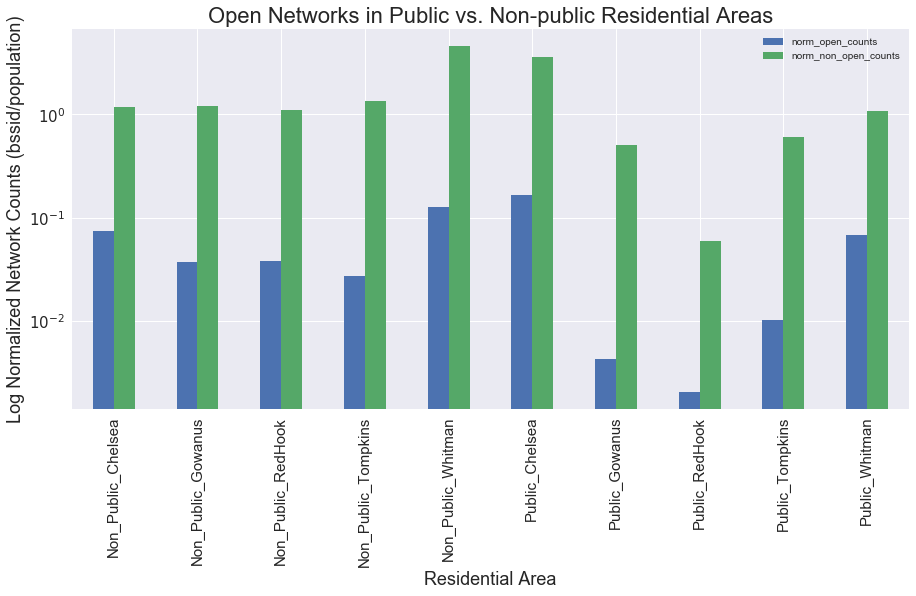

In [1966]:
ax = bar_plot.plot(kind='bar', title ="Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(15, 7), legend=True, fontsize=15)
ax.set_title("Open Networks in Public vs. Non-public Residential Areas",fontsize=22)
ax.set_xlabel("Residential Area", fontsize=18)
ax.set_ylabel("Log Normalized Network Counts (bssid/population)", fontsize=18)
ax.set_yscale("log")

In [1968]:
bar_plot

,name,norm_open_counts,norm_non_open_counts
Non_Public_Chelsea,Non_Public_Chelsea,0.074869,1.185723
Non_Public_Gowanus,Non_Public_Gowanus,0.037736,1.218160
Non_Public_RedHook,Non_Public_RedHook,0.038108,1.101183
Non_Public_Tompkins,Non_Public_Tompkins,0.027498,1.361137
Non_Public_Whitman,Non_Public_Whitman,0.128205,4.571795
Public_Chelsea,Public_Chelsea,0.167529,3.567270
Public_Gowanus,Public_Gowanus,0.004346,0.501087
Public_RedHook,Public_RedHook,0.002061,0.059494
Public_Tompkins,Public_Tompkins,0.010292,0.611405
Public_Whitman,Public_Whitman,0.068071,1.085900


In [1969]:
#contingency_table_Chelsea = bar_plot[bar_blot.index.str.contains("Chelsea","Chelsea_None")][["norm_open_counts","norm_non_open_counts"]]

In [1970]:
#contingency_table_Chelsea

In [1971]:
#from scipy.stats import chisquare

In [1972]:
#obs = np.array([[0.104140,3.033635],[0.232414,2.323579]])

In [1973]:
#obs

In [1974]:
#chisquare(obs)

In [1975]:
#obs

In [1976]:
#chisquare(obs)

In [1977]:
#area_MHI = housing_gdf.groupby(["name"])["MHI"].unique()

In [1978]:
#housing_gdf.groupby(["name", "GEOID"])["MHI"].unique()

In [1979]:
#area_MHI

In [1980]:
#area_MHI = pd.DataFrame(area_MHI)

In [1981]:
#area_MHI

In [1982]:
#area_MHI["MHI"] = list(map(lambda x: x[:].sum(), list(area_MHI.MHI)))

In [1983]:
#area_MHI.MHI[2].sum()

In [1984]:
#area_MHI["name"] = area_MHI.index

In [1985]:
#scatter_plot = bar_plot.merge(area_MHI, on="name")

In [1387]:
#scatter_plot.index = scatter_plot.name

In [1987]:
#scatter_plot

In [1375]:
#scatter_plot["mih_v_norm_open_counts"] = zip(scatter_plot.norm_open_counts,scatter_plot.MHI)
#scatter_plot["mih_v_norm_non_open_counts"] = zip(scatter_plot.norm_non_open_counts,scatter_plot.MHI)

In [ ]:
housing_gdf_.groupby(["GEOID","open_net"])[]

In [2015]:
housing_gdf_.groupby(housing_gdf_.GEOID)["open_net"].sum()

GEOID
360470029011     102.0
360470029012     168.0
360470033001     373.0
360470043004      76.0
360470065001      16.0
360470065002       4.0
360470065003       8.0
360470065004      10.0
360470065005      20.0
360470069003     558.0
360470069004     164.0
360470071003     121.0
360470085001      60.0
360470127003     399.0
360470181001     529.0
360470181002     382.0
360470181003     356.0
360470259021      40.0
360470261001       6.0
360470261002      24.0
360470261003      18.0
360470261004      30.0
360470261005      12.0
360470281001      26.0
360470283001      21.0
360470285021      27.0
360470287003       1.0
360470289004      10.0
360610083003    5035.0
360610089003    1638.0
360610091002    2278.0
360610091003    1184.0
360610097002    4956.0
Name: open_net, dtype: float64

In [2016]:
open_counts = pd.DataFrame(housing_gdf_.groupby(["GEOID"])["open_net"].sum())

In [2017]:
housing_gdf_.groupby(["GEOID","bssid"])["open_net"].sum()

GEOID         bssid            
360470029011  00:06:66:23:72:ee      0.0
              00:0c:42:3a:bb:44      0.0
              00:19:9d:ff:74:7f      0.0
              00:22:6b:7d:be:1a      0.0
              00:24:01:6c:5e:e9      0.0
              00:ac:e0:96:d7:45      0.0
              00:ac:e0:9f:4a:20      0.0
              00:ac:e0:9f:4a:25      0.0
              00:ac:e0:a4:f9:60      0.0
              00:ac:e0:a4:f9:65      0.0
              04:a1:51:da:17:59      0.0
              04:a1:51:da:17:5a      0.0
              08:02:8e:ce:5f:a5      0.0
              08:3e:0c:d8:30:b5      0.0
              08:3e:0c:d9:28:70      0.0
              08:3e:0c:d9:28:75      0.0
              08:3e:0c:da:7f:f0      0.0
              08:3e:0c:da:7f:f5      0.0
              08:3e:0c:db:18:e0      0.0
              08:3e:0c:db:18:e5      0.0
              08:3e:8e:90:07:4f      0.0
              08:86:3b:30:2e:60      0.0
              08:86:3b:78:c5:e8      0.0
              08:95:2a:cd

In [2018]:
open_counts_by_bssid = pd.DataFrame(housing_gdf_.groupby(["GEOID","bssid"])["open_net"].sum())

In [2019]:
open_counts_by_bssid

open_net
GEOID        bssid                      
360470029011 00:06:66:23:72:ee       0.0
             00:0c:42:3a:bb:44       0.0
             00:19:9d:ff:74:7f       0.0
             00:22:6b:7d:be:1a       0.0
             00:24:01:6c:5e:e9       0.0
             00:ac:e0:96:d7:45       0.0
             00:ac:e0:9f:4a:20       0.0
             00:ac:e0:9f:4a:25       0.0
             00:ac:e0:a4:f9:60       0.0
             00:ac:e0:a4:f9:65       0.0
             04:a1:51:da:17:59       0.0
             04:a1:51:da:17:5a       0.0
             08:02:8e:ce:5f:a5       0.0
             08:3e:0c:d8:30:b5       0.0
             08:3e:0c:d9:28:70       0.0
             08:3e:0c:d9:28:75       0.0
             08:3e:0c:da:7f:f0       0.0
             08:3e:0c:da:7f:f5       0.0
             08:3e:0c:db:18:e0       0.0
             08:3e:0c:db:18:e5       0.0
             08:3e:8e:90:07:4f       0.0
             08:86:3b:30:2e:60       0.0
             08:86:3b:78:c5:e8       0.0
             08:95:2a:cd:cb:94       0.0
             08:95:2a:ec:94:a5       0.0
             0a:47:c9:35:6e:58       0.0
             0c:f8:93:bc:27:a0       0.0
             10:0d:7f:d1:9b:70       0.0
             10:0d:7f:d1:bf:3f       0.0
             10:78:5b:17:3d:b1       0.0
...                                  ...
360610097002 f8:e7:1e:55:dd:08       0.0
             f8:e7:1e:55:dd:0c       0.0
             f8:e7:1e:6c:81:a8       0.0
             f8:e7:1e:6c:81:ac       0.0
             f8:e7:1e:95:dd:08       0.0
             f8:e7:1e:95:dd:0c       0.0
             f8:e7:1e:ac:81:a8     391.0
             f8:e7:1e:ac:81:ac     382.0
             f8:e7:1e:ec:81:a8       0.0
             f8:e7:1e:ec:81:ac       0.0
             fa:8f:ca:3b:fc:b1       0.0
             fa:8f:ca:50:4b:41       0.0
             fa:8f:ca:52:1f:d8       0.0
             fa:8f:ca:8d:cb:ae       0.0
             fa:8f:ca:8e:0e:fc       0.0
             fc:15:b4:6f:92:0b       0.0
             fc:52:8d:0b:13:74       0.0
             fc:52:8d:0b:13:75       0.0
             fc:52:8d:0c:b1:08       0.0
             fc:52:8d:42:e3:63       0.0
             fc:52:8d:42:e3:64       0.0
             fc:52:8d:43:52:8d       0.0
             fc:52:8d:43:52:8e       0.0
             fc:52:8d:4f:6c:6d       0.0
             fc:52:8d:4f:6c:6e       0.0
             fc:52:8d:58:ec:6b       0.0
             fc:52:8d:ff:6c:39       0.0
             fc:52:8d:ff:6c:3a       0.0
             fe:1e:df:fc:cd:f3      34.0
             fe:a6:67:db:16:0a       0.0

[23170 rows x 1 columns]

In [2020]:
open_counts_by_bssid["open_net_counts"] = list(map(lambda x: x > 0, open_counts_by_bssid.open_net))
open_counts_by_bssid["non_open_net_counts"] = list(map(lambda x: x == 0, open_counts_by_bssid.open_net))

In [2021]:
open_counts_by_bssid["GEOID"] = list(map(lambda x: list(x),open_counts_by_bssid.index))
open_counts_by_bssid["GEOID"] = list(map(lambda x: x[0][:], open_counts_by_bssid["GEOID"]))

In [2023]:
open_counts_by_bssid_ = pd.DataFrame(open_counts_by_bssid.groupby(open_counts_by_bssid.GEOID)[["open_net_counts","non_open_net_counts"]].sum())

In [2027]:
open_counts_by_bssid_.head()

,open_net_counts,non_open_net_counts,GEOID
GEOID,,,
360470029011,23.0,367.0,360470029011
360470029012,28.0,383.0,360470029012
360470033001,31.0,1525.0,360470033001
360470043004,9.0,116.0,360470043004
360470065001,9.0,247.0,360470065001


In [2026]:
open_counts_by_bssid_["GEOID"] = open_counts_by_bssid_.index

In [2028]:
housing_bg_final = housing_gdf_.merge(open_counts_by_bssid_, on="GEOID", how="inner")

In [2032]:
housing_bg_final.head()

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,...,index_right,cartodb_id,descriptio,name,uni_bssid_by_housing_area,open_net,open_net_counts,non_open_net_counts,norm_open_counts,norm_non_open_counts
0,114476,0,1,047,S,360470085001,+40.6766988,-074.0086120,G5030,Block Group 1,...,0,8,,Public_RedHook,448,False,15.0,433.0,0.002061,0.059494
1,114476,0,1,047,S,360470085001,+40.6766988,-074.0086120,G5030,Block Group 1,...,0,8,,Public_RedHook,448,False,15.0,433.0,0.002061,0.059494
2,114476,0,1,047,S,360470085001,+40.6766988,-074.0086120,G5030,Block Group 1,...,0,8,,Public_RedHook,448,False,15.0,433.0,0.002061,0.059494
3,114476,0,1,047,S,360470085001,+40.6766988,-074.0086120,G5030,Block Group 1,...,0,8,,Public_RedHook,448,False,15.0,433.0,0.002061,0.059494
4,114476,0,1,047,S,360470085001,+40.6766988,-074.0086120,G5030,Block Group 1,...,0,8,,Public_RedHook,448,False,15.0,433.0,0.002061,0.059494


In [2030]:
housing_bg_final.columns

Index(['ALAND', 'AWATER', 'BLKGRPCE', 'COUNTYFP', 'FUNCSTAT', 'GEOID',
       'INTPTLAT', 'INTPTLON', 'MTFCC', 'NAMELSAD', 'STATEFP', 'TRACTCE',
       'geometry', 'acc', 'bssid', 'lat', 'level', 'lng', 'ssid', 'time',
       'uni_bssid_count', 'Geo_NAME_x', 'Geo_QName_x', 'Geo_AREALAND_x',
       'Geo_AREAWATR_x', 'Geo_SUMLEV_x', 'Geo_GEOCOMP_x', 'Geo_REGION_x',
       'Geo_DIVISION_x', 'Geo_STATE_x', 'Geo_COUNTY_x', 'Geo_TRACT_x',
       'Geo_BLKGRP_x', 'MHI', 'Geo_NAME_y', 'Geo_QName_y', 'Geo_AREALAND_y',
       'Geo_AREAWATR_y', 'Geo_SUMLEV_y', 'Geo_GEOCOMP_y', 'Geo_REGION_y',
       'Geo_DIVISION_y', 'Geo_STATE_y', 'Geo_COUNTY_y', 'Geo_TRACT_y',
       'Geo_BLKGRP_y', 'SE_T003_003', 'Population', 'Pop_Density', 'Geo_NAME',
       'Geo_QName', 'Geo_AREALAND', 'Geo_AREAWATR', 'Geo_SUMLEV',
       'Geo_GEOCOMP', 'Geo_REGION', 'Geo_DIVISION', 'Geo_STATE', 'Geo_COUNTY',
       'Geo_TRACT', 'Geo_BLKGRP', 'Pop_over_25', 'Less_than_HS', 'High_School',
       'Some_College', 'Bachelors', '

In [2031]:
housing_bg_final["norm_open_counts"] = list(map(lambda x,y: x/y,\
                                                              housing_bg_final.open_net_counts,\
                                                              housing_bg_final.Population))
housing_bg_final["norm_non_open_counts"] = list(map(lambda x,y: x/y, housing_bg_final.non_open_net_counts,\
                                                                 housing_bg_final.Population))

In [2033]:
bar_plot_bg = housing_bg_final[["GEOID","norm_open_counts","norm_non_open_counts"]]

In [2037]:
bar_plot_bg = bar_plot_bg.drop_duplicates(subset="GEOID", keep='first', inplace=False)

In [2041]:
bar_plot_bg.index = bar_plot_bg.GEOID

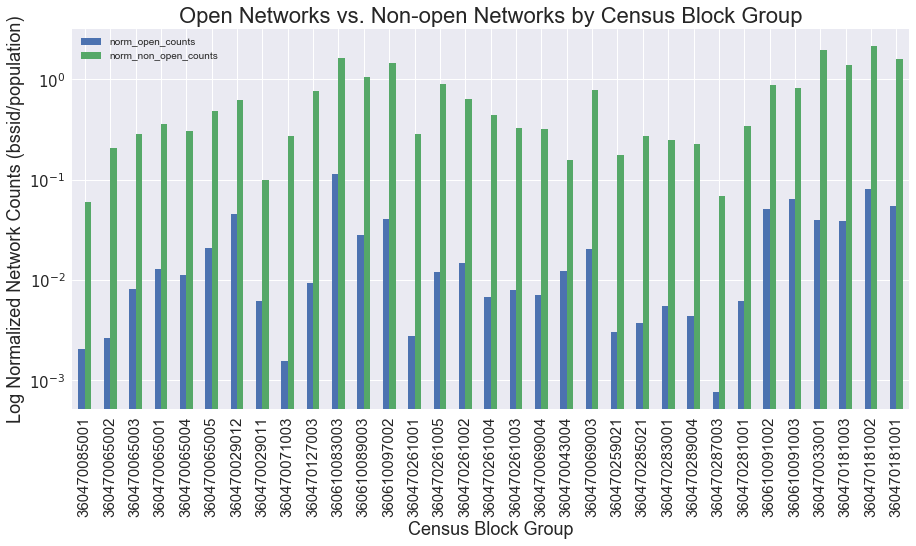

In [2042]:
ax = bar_plot_bg.plot(kind='bar', figsize=(15, 7), legend=True, fontsize=15)
ax.set_title("Open Networks vs. Non-open Networks by Census Block Group",fontsize=22)
ax.set_xlabel("Census Block Group", fontsize=18)
ax.set_ylabel("Log Normalized Network Counts (bssid/population)", fontsize=18)
ax.set_yscale("log")

In [2047]:
housing_bg_final.columns

Index(['ALAND', 'AWATER', 'BLKGRPCE', 'COUNTYFP', 'FUNCSTAT', 'GEOID',
       'INTPTLAT', 'INTPTLON', 'MTFCC', 'NAMELSAD', 'STATEFP', 'TRACTCE',
       'geometry', 'acc', 'bssid', 'lat', 'level', 'lng', 'ssid', 'time',
       'uni_bssid_count', 'Geo_NAME_x', 'Geo_QName_x', 'Geo_AREALAND_x',
       'Geo_AREAWATR_x', 'Geo_SUMLEV_x', 'Geo_GEOCOMP_x', 'Geo_REGION_x',
       'Geo_DIVISION_x', 'Geo_STATE_x', 'Geo_COUNTY_x', 'Geo_TRACT_x',
       'Geo_BLKGRP_x', 'MHI', 'Geo_NAME_y', 'Geo_QName_y', 'Geo_AREALAND_y',
       'Geo_AREAWATR_y', 'Geo_SUMLEV_y', 'Geo_GEOCOMP_y', 'Geo_REGION_y',
       'Geo_DIVISION_y', 'Geo_STATE_y', 'Geo_COUNTY_y', 'Geo_TRACT_y',
       'Geo_BLKGRP_y', 'SE_T003_003', 'Population', 'Pop_Density', 'Geo_NAME',
       'Geo_QName', 'Geo_AREALAND', 'Geo_AREAWATR', 'Geo_SUMLEV',
       'Geo_GEOCOMP', 'Geo_REGION', 'Geo_DIVISION', 'Geo_STATE', 'Geo_COUNTY',
       'Geo_TRACT', 'Geo_BLKGRP', 'Pop_over_25', 'Less_than_HS', 'High_School',
       'Some_College', 'Bachelors', '

In [2059]:
housing_scatter_plot = housing_bg_final[["name","GEOID","geometry","uni_bssid_count","MHI","Population",\
                                     "Pop_Density","Geo_TRACT","Geo_BLKGRP","Pop_over_25",\
                                     "Less_than_HS","High_School","Some_College","Bachelors",\
                                     "Masters","Professional_School_Degree","Doctorate",\
                                     "norm_open_counts","norm_non_open_counts"]]

In [2060]:
housing_scatter_plot = housing_scatter_plot.drop_duplicates(subset="GEOID", keep='first', inplace=False)

In [2061]:
housing_scatter_plot.columns

Index(['name', 'GEOID', 'geometry', 'uni_bssid_count', 'MHI', 'Population',
       'Pop_Density', 'Geo_TRACT', 'Geo_BLKGRP', 'Pop_over_25', 'Less_than_HS',
       'High_School', 'Some_College', 'Bachelors', 'Masters',
       'Professional_School_Degree', 'Doctorate', 'norm_open_counts',
       'norm_non_open_counts'],
      dtype='object')

In [2063]:
housing_scatter_plot.shape

(33, 19)

In [2064]:
scatter_plot = housing_scatter_plot[["name","GEOID","MHI","norm_open_counts","norm_non_open_counts"]]

In [2090]:
def public(x):
    if "Non" in str(x):
        return False
    else:
        return True

In [2096]:
scatter_plot["Public"] = list(map(lambda x: public(x), scatter_plot.name))
scatter_plot["Public_cat"] = list(map(lambda x: "public" if x == True else "non-public", scatter_plot.Public))

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [2097]:
scatter_plot.head()

,name,GEOID,MHI,norm_open_counts,norm_non_open_counts,Public,Public_cat
0,Public_RedHook,360470085001,10372,0.002061,0.059494,True,public
1416,Non_Public_RedHook,360470065002,63889,0.002628,0.206307,False,non-public
1651,Non_Public_RedHook,360470065003,66181,0.008230,0.286694,False,non-public
1986,Non_Public_RedHook,360470065001,68750,0.013006,0.356936,False,non-public
2447,Non_Public_RedHook,360470065004,71875,0.011200,0.304000,False,non-public


### scatter plots

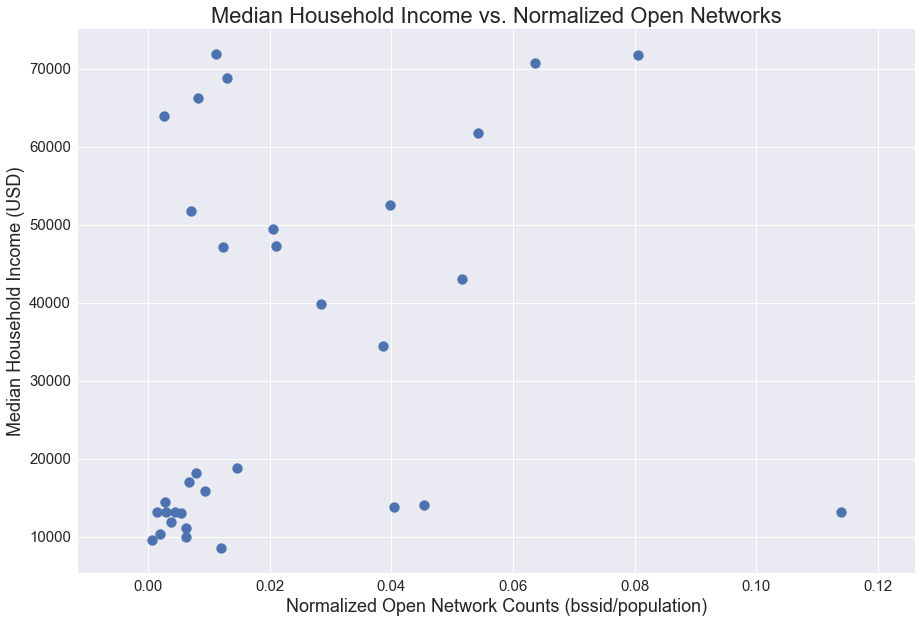

In [2099]:
ax = scatter_plot.plot(kind='scatter', figsize=(15, 10), legend=True, fontsize=15,\
                       x='norm_open_counts', y='MHI', s=100)
ax.set_title("Median Household Income vs. Normalized Open Networks",fontsize=22)
ax.set_xlabel("Normalized Open Network Counts (bssid/population)", fontsize=18)
ax.set_ylabel("Median Household Income (USD)", fontsize=18)
#ax.set_yscale("log")

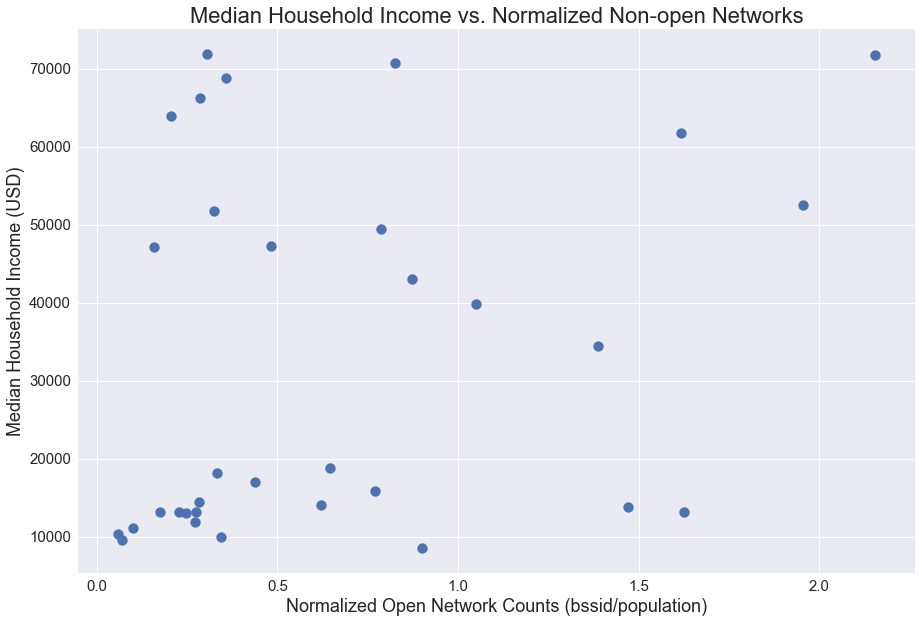

In [2100]:
ax = scatter_plot.plot(kind='scatter', figsize=(15, 10), legend=True, fontsize=15,\
                       x='norm_non_open_counts', y='MHI', s=100)
ax.set_title("Median Household Income vs. Normalized Non-open Networks",fontsize=22)
ax.set_xlabel("Normalized Open Network Counts (bssid/population)", fontsize=18)
ax.set_ylabel("Median Household Income (USD)", fontsize=18)
#ax.set_yscale("log")

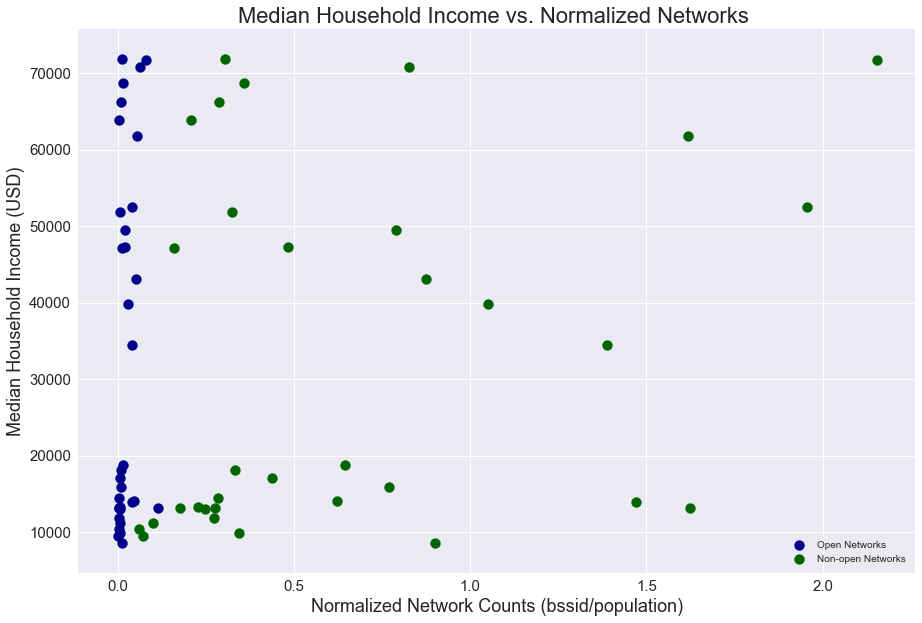

In [2103]:
ax = scatter_plot.plot(kind='scatter', figsize=(15, 10), legend=True, fontsize=15,\
                       x='norm_open_counts', y='MHI', s=100, color='DarkBlue',\
                       label='Open Networks')

scatter_plot.plot(kind='scatter', figsize=(15, 10), legend=True, fontsize=15,\
                  x='norm_non_open_counts', y='MHI', s=100,\
                  color='DarkGreen', label='Non-open Networks', ax=ax)
ax.set_title("Median Household Income vs. Normalized Networks ",fontsize=22)
ax.set_xlabel("Normalized Network Counts (bssid/population)", fontsize=18)
ax.set_ylabel("Median Household Income (USD)", fontsize=18)
ax.legend()

In [2104]:
import statsmodels.api as sm

In [2105]:
scatter_plot.columns

Index(['name', 'GEOID', 'MHI', 'norm_open_counts', 'norm_non_open_counts',
       'Public', 'Public_cat'],
      dtype='object')

In [2106]:
# Open Networks
X = scatter_plot.norm_open_counts
y = scatter_plot.MHI

print(y.describe())

X = sm.add_constant(X)
model1 = sm.OLS(y, X).fit()

predictions1 = model1.predict(X)
print(predictions1)

model1.summary()

count       33.000000
mean     32732.424242
std      23229.770313
min       8561.000000
25%      13210.000000
50%      18167.000000
75%      51793.000000
max      71875.000000
Name: MHI, dtype: float64
[ 27708.51710712  27848.4544217   29230.84616789  30409.17223223
  29963.59065222  32394.75629979  38397.82154073  28740.90747136
  27582.99566544  29520.51831788  55290.84701432  34207.14032304
  37187.576245    27878.47190471  30157.61281409  30822.75776511
  28883.45738652  29163.50902398  28945.85123513  30229.66638324
  32284.56360662  27954.9738074   28129.18836286  28553.26461851
  28286.97519227  27389.04060765  28742.16368025  39945.75605216
  42909.80375893  37006.80487238  36746.08508203  47060.55907786
  40596.35130959]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    MHI   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     2.640
Date:                Fri, 21 Jul 2017   Prob (F-statistic):              0.114
Time:                        02:00:12   Log-Likelihood:                -376.72
No. Observations:                  33   AIC:                             757.4
Df Residuals:                      31   BIC:                             760.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              2.72e+04   5210.291      5.220      0.000      1.66e+04  3.78e+04
norm_open_counts  2.468e+05   1.52e+05      1.625      0.114      -6.3e+04  5.56e+05
==============================================================================
Omnibus:                        4.031   Durbin-Watson:                   0.871
Prob(Omnibus):                  0.133   Jarque-Bera (JB):                2.274
Skew:                           0.402   Prob(JB):                        0.321
Kurtosis:                       1.997   Cond. No.                         38.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2107]:
# Non-Open Networks
X2 = scatter_plot.norm_non_open_counts
y = scatter_plot.MHI

print(y.describe())

X2 = sm.add_constant(X2)
model2 = sm.OLS(y, X2).fit()

predictions2 = model2.predict(X2)
print(predictions2)

model2.summary()

count       33.000000
mean     32732.424242
std      23229.770313
min       8561.000000
25%      13210.000000
50%      18167.000000
75%      51793.000000
max      71875.000000
Name: MHI, dtype: float64
[ 25875.73182281  27565.5158234   28490.74652793  29299.21879953
  28689.93328779  30743.92085689  32335.59886425  26337.87935638
  28353.38086506  34042.77807276  43892.46668326  37268.82216284
  42108.48795947  28461.38382149  35557.63439111  32607.53306815
  30239.10676696  29007.199704    28923.49457505  27012.42876678
  34259.26261038  27214.37869389  28315.66311915  28031.58336091
  27817.4223997   25993.56224606  29133.05909593  35244.47177701
  34704.52264212  47694.02472253  41153.50696869  49979.06143856
  43816.21874916]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    MHI   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     2.723
Date:                Fri, 21 Jul 2017   Prob (F-statistic):              0.109
Time:                        02:00:17   Log-Likelihood:                -376.68
No. Observations:                  33   AIC:                             757.4
Df Residuals:                      31   BIC:                             760.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                 2.519e+04   6033.243      4.175      0.000      1.29e+04  3.75e+04
norm_non_open_counts  1.151e+04   6974.490      1.650      0.109     -2714.806  2.57e+04
==============================================================================
Omnibus:                        5.316   Durbin-Watson:                   0.812
Prob(Omnibus):                  0.070   Jarque-Bera (JB):                3.336
Skew:                           0.594   Prob(JB):                        0.189
Kurtosis:                       1.993   Cond. No.                         2.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2108]:
scatter_plot

,name,GEOID,MHI,norm_open_counts,norm_non_open_counts,Public,Public_cat
0,Public_RedHook,360470085001,10372,0.002061,0.059494,True,public
1416,Non_Public_RedHook,360470065002,63889,0.002628,0.206307,False,non-public
1651,Non_Public_RedHook,360470065003,66181,0.008230,0.286694,False,non-public
1986,Non_Public_RedHook,360470065001,68750,0.013006,0.356936,False,non-public
2447,Non_Public_RedHook,360470065004,71875,0.011200,0.304000,False,non-public
2844,Non_Public_RedHook,360470065005,47260,0.021053,0.482456,False,non-public
3431,Public_Whitman,360470029012,14091,0.045381,0.620746,True,public
4870,Public_Whitman,360470029011,11185,0.006245,0.099647,True,public
6320,Public_Gowanus,360470071003,13202,0.001552,0.274759,True,public
22628,Public_Gowanus,360470127003,15868,0.009404,0.769070,True,public


In [2109]:
scatter_plot["predictions_open"] = predictions1
scatter_plot["predictions_non_open"] = predictions2

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [2115]:
scatter_plot.head()

,name,GEOID,MHI,norm_open_counts,norm_non_open_counts,Public,Public_cat,predictions_open,predictions_non_open
0,Public_RedHook,360470085001,10372,0.002061,0.059494,True,public,27708.517107,25875.731823
1416,Non_Public_RedHook,360470065002,63889,0.002628,0.206307,False,non-public,27848.454422,27565.515823
1651,Non_Public_RedHook,360470065003,66181,0.008230,0.286694,False,non-public,29230.846168,28490.746528
1986,Non_Public_RedHook,360470065001,68750,0.013006,0.356936,False,non-public,30409.172232,29299.218800
2447,Non_Public_RedHook,360470065004,71875,0.011200,0.304000,False,non-public,29963.590652,28689.933288


In [2113]:
X2.head()

,const,norm_non_open_counts
0,1.0,0.059494
1416,1.0,0.206307
1651,1.0,0.286694
1986,1.0,0.356936
2447,1.0,0.304000


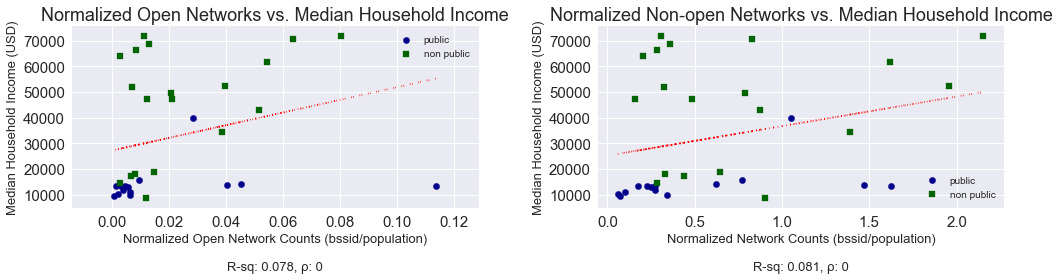

In [2132]:
ax1 = plt.subplot(1,2,1)

scatter_plot[scatter_plot.Public_cat == "public"].plot(kind='scatter', title ="Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(15, 4), legend=True, fontsize=15, x='norm_open_counts', \
                  y='MHI', s=40, color='DarkBlue',\
                      label='public', ax=ax1, marker="o")
scatter_plot[scatter_plot.Public_cat == "non-public"].plot(kind='scatter', title ="Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(15, 4), legend=True, fontsize=15, x='norm_open_counts', \
                  y='MHI', s=40, color='DarkGreen',\
                      label='non public', ax=ax1, marker="s")
plt.plot(X.norm_open_counts, predictions1, color="red", linestyle='--', dashes=(.3, 4))

ax1.set_title("Normalized Open Networks vs. Median Household Income",fontsize=18)
ax1.set_xlabel("Normalized Open Network Counts (bssid/population)\n\nR-sq: {:.2}, ρ: {}".format(model1.rsquared,"na"),\
               fontsize=13)
ax1.set_ylabel("Median Household Income (USD)", fontsize=13)


ax2 = plt.subplot(1,2,2)

scatter_plot[scatter_plot.Public_cat == "public"].plot(kind='scatter', title ="Non-Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(15, 4), legend=True, fontsize=15, x='norm_non_open_counts', y='MHI', s=40,\
                       color='DarkBlue', label='public', ax=ax2, marker="o")
scatter_plot[scatter_plot.Public_cat == "non-public"].plot(kind='scatter', title ="Non-Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(15, 4), legend=True, fontsize=15, x='norm_non_open_counts', y='MHI', s=40,\
                       color='DarkGreen', label='non public', ax=ax2, marker="s")
plt.plot(X2.norm_non_open_counts, predictions2, color="red", linestyle='--', dashes=(.3, 4))

ax2.set_title("Normalized Non-open Networks vs. Median Household Income",fontsize=18)
ax2.set_xlabel("Normalized Network Counts (bssid/population)\n\nR-sq: {:.2}, ρ: {}".format(model2.rsquared,"na"), fontsize=13)
ax2.set_ylabel("Median Household Income (USD)", fontsize=13)
plt.tight_layout()

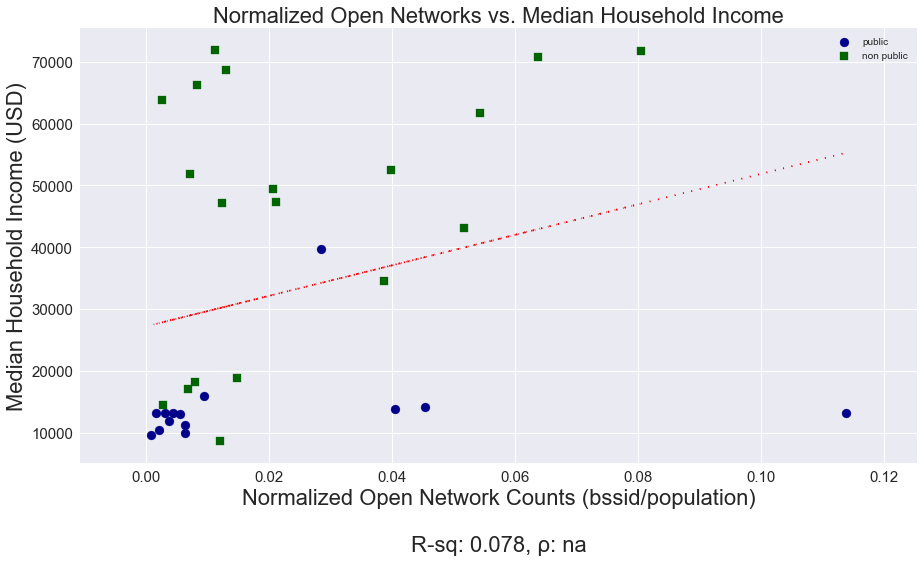

In [2152]:
ax1 = plt.subplot()

scatter_plot[scatter_plot.Public_cat == "public"].plot(kind='scatter', title ="Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(15, 8), legend=True, fontsize=15, x='norm_open_counts', \
                  y='MHI', s=80, color='DarkBlue',\
                      label='public', ax=ax1, marker="o")
scatter_plot[scatter_plot.Public_cat == "non-public"].plot(kind='scatter', title ="Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(15, 8), legend=True, fontsize=15, x='norm_open_counts', \
                  y='MHI', s=80, color='DarkGreen',\
                      label='non public', ax=ax1, marker="s")
plt.plot(X.norm_open_counts, predictions1, color="red", linestyle='--', dashes=(.3, 4))

ax1.set_title("Normalized Open Networks vs. Median Household Income",fontsize=22)
ax1.set_xlabel("Normalized Open Network Counts (bssid/population)\n\nR-sq: {:.2}, ρ: {}".format(model1.rsquared,"na"),\
               fontsize=22)
ax1.set_ylabel("Median Household Income (USD)", fontsize=22)

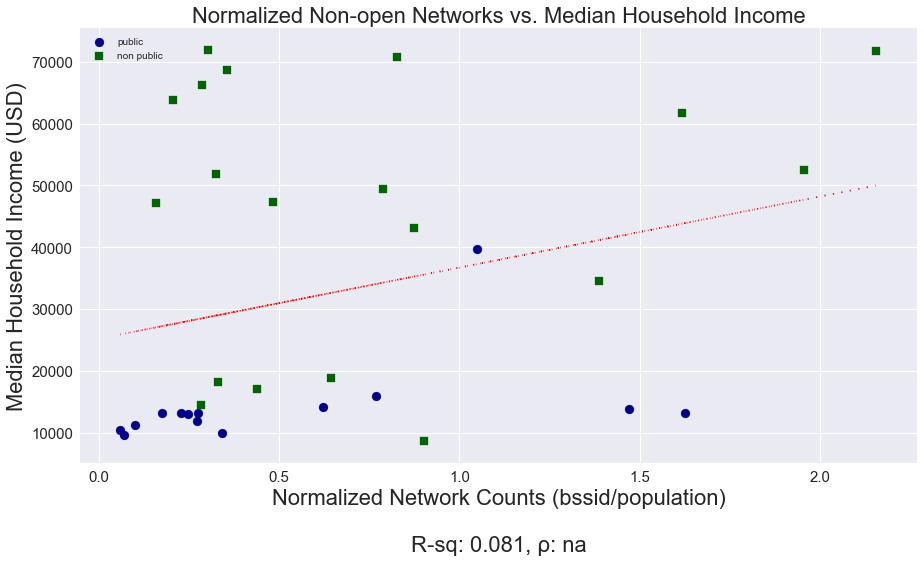

In [2151]:
ax2 = plt.subplot()

scatter_plot[scatter_plot.Public_cat == "public"].plot(kind='scatter', title ="Non-Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(15, 8), legend=True, fontsize=15, x='norm_non_open_counts', y='MHI', s=80,\
                       color='DarkBlue', label='public', ax=ax2, marker="o")
scatter_plot[scatter_plot.Public_cat == "non-public"].plot(kind='scatter', title ="Non-Open Networks in Public vs. Non-public Residential Areas", \
                   figsize=(15, 8), legend=True, fontsize=15, x='norm_non_open_counts', y='MHI', s=80,\
                       color='DarkGreen', label='non public', ax=ax2, marker="s")
plt.plot(X2.norm_non_open_counts, predictions2, color="red", linestyle='--', dashes=(.3, 4))

ax2.set_title("Normalized Non-open Networks vs. Median Household Income",fontsize=22)
ax2.set_xlabel("Normalized Network Counts (bssid/population)\n\nR-sq: {:.2}, ρ: {}".format(model2.rsquared,"na"), fontsize=22)
ax2.set_ylabel("Median Household Income (USD)", fontsize=22)

# Poisson Regression

In [1456]:
housing_wifi_counts_normalized

,open_net_counts,non_open_net_counts,name,Population,norm_open_counts,norm_non_open_counts
0,161.0,4690.0,Chelsea,1546,0.104140,3.033635
1,413.0,4129.0,Chelsea_None,1777,0.232414,2.323579
2,14.0,1614.0,Gowanus,957,0.014629,1.686520
3,17.0,650.0,Gowanus_None,825,0.020606,0.787879
4,42.0,670.0,Ingersoll,3683,0.011404,0.181917
5,111.0,3107.0,Ingersoll_None,780,0.142308,3.983333
6,14.0,299.0,RedHook,7278,0.001924,0.041083
7,38.0,2298.0,Tompkins,3595,0.010570,0.639221
8,30.0,1485.0,Tompkins_None,584,0.051370,2.542808


In [1457]:
scatter_plot

,name,norm_open_counts,norm_non_open_counts,MHI
name,,,,
Chelsea,Chelsea,0.104140,3.033635,221383
Chelsea_None,Chelsea_None,0.232414,2.323579,221729
Gowanus,Gowanus,0.014629,1.686520,29070
Gowanus_None,Gowanus_None,0.020606,0.787879,49444
Ingersoll,Ingersoll,0.011404,0.181917,25276
Ingersoll_None,Ingersoll_None,0.142308,3.983333,374253
RedHook,RedHook,0.001924,0.041083,10372
Tompkins,Tompkins,0.010570,0.639221,85194
Tompkins_None,Tompkins_None,0.051370,2.542808,77051


In [1468]:
final_data = housing_wifi_counts_normalized.merge(scatter_plot, on="name")

In [1469]:
final_data["norm_open_counts"] = final_data.norm_open_counts_x
final_data["norm_non_open_counts"] = final_data.norm_non_open_counts_x
del final_data["norm_open_counts_x"]
del final_data["norm_non_open_counts_x"]
del final_data["norm_open_counts_y"]
del final_data["norm_non_open_counts_y"]

In [1470]:
final_data

,open_net_counts,non_open_net_counts,name,Population,MHI,norm_open_counts,norm_non_open_counts
0,161.0,4690.0,Chelsea,1546,221383,0.104140,3.033635
1,413.0,4129.0,Chelsea_None,1777,221729,0.232414,2.323579
2,14.0,1614.0,Gowanus,957,29070,0.014629,1.686520
3,17.0,650.0,Gowanus_None,825,49444,0.020606,0.787879
4,42.0,670.0,Ingersoll,3683,25276,0.011404,0.181917
5,111.0,3107.0,Ingersoll_None,780,374253,0.142308,3.983333
6,14.0,299.0,RedHook,7278,10372,0.001924,0.041083
7,38.0,2298.0,Tompkins,3595,85194,0.010570,0.639221
8,30.0,1485.0,Tompkins_None,584,77051,0.051370,2.542808


In [1482]:
#dummies = pd.get_dummies(df['Category'])
area_dummies = pd.get_dummies(final_data['name'])
area_dummies["name"] = final_data.name
area_dummies

,Chelsea,Chelsea_None,Gowanus,Gowanus_None,Ingersoll,Ingersoll_None,RedHook,Tompkins,Tompkins_None,name
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Chelsea
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Chelsea_None
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Gowanus
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Gowanus_None
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Ingersoll
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Ingersoll_None
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,RedHook
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Tompkins
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Tompkins_None


In [1484]:
final_data = final_data.merge(area_dummies, on="name")

In [1508]:
# 1 = public housing, 0 = non public housing
final_data["Public"] = [1.,0.,1.,0.,1.,0.,1.,1.,0.]
final_data["Public_cat"] = ["public","non_public","public","non_public",\
                            "public","non_public","public","public","non_public"]

In [1509]:
final_data

,open_net_counts,non_open_net_counts,name,Population,MHI,norm_open_counts,norm_non_open_counts,Chelsea,Chelsea_None,Gowanus,Gowanus_None,Ingersoll,Ingersoll_None,RedHook,Tompkins,Tompkins_None,Public,Public_cat
0,161.0,4690.0,Chelsea,1546,221383,0.104140,3.033635,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,public
1,413.0,4129.0,Chelsea_None,1777,221729,0.232414,2.323579,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,non_public
2,14.0,1614.0,Gowanus,957,29070,0.014629,1.686520,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,public
3,17.0,650.0,Gowanus_None,825,49444,0.020606,0.787879,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,non_public
4,42.0,670.0,Ingersoll,3683,25276,0.011404,0.181917,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,public
5,111.0,3107.0,Ingersoll_None,780,374253,0.142308,3.983333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,non_public
6,14.0,299.0,RedHook,7278,10372,0.001924,0.041083,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,public
7,38.0,2298.0,Tompkins,3595,85194,0.010570,0.639221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,public
8,30.0,1485.0,Tompkins_None,584,77051,0.051370,2.542808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,non_public


In [1522]:
Data = final_data[["Public", "Public_cat","name","Population","open_net_counts","non_open_net_counts","MHI",\
                  "Chelsea","Chelsea_None","Gowanus","Gowanus_None","Ingersoll","Ingersoll_None",\
                   "RedHook","Tompkins","Tompkins_None", "norm_open_counts", "norm_non_open_counts"]]

In [1523]:
# should I add population density and household desity???????
Data

,Public,Public_cat,name,Population,open_net_counts,non_open_net_counts,MHI,Chelsea,Chelsea_None,Gowanus,Gowanus_None,Ingersoll,Ingersoll_None,RedHook,Tompkins,Tompkins_None,norm_open_counts,norm_non_open_counts
0,1.0,public,Chelsea,1546,161.0,4690.0,221383,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.104140,3.033635
1,0.0,non_public,Chelsea_None,1777,413.0,4129.0,221729,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.232414,2.323579
2,1.0,public,Gowanus,957,14.0,1614.0,29070,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014629,1.686520
3,0.0,non_public,Gowanus_None,825,17.0,650.0,49444,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.020606,0.787879
4,1.0,public,Ingersoll,3683,42.0,670.0,25276,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.011404,0.181917
5,0.0,non_public,Ingersoll_None,780,111.0,3107.0,374253,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.142308,3.983333
6,1.0,public,RedHook,7278,14.0,299.0,10372,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.001924,0.041083
7,1.0,public,Tompkins,3595,38.0,2298.0,85194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.010570,0.639221
8,0.0,non_public,Tompkins_None,584,30.0,1485.0,77051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.051370,2.542808


In [1520]:
final_data.columns

Index(['open_net_counts', 'non_open_net_counts', 'name', 'Population', 'MHI',
       'norm_open_counts', 'norm_non_open_counts', 'Chelsea', 'Chelsea_None',
       'Gowanus', 'Gowanus_None', 'Ingersoll', 'Ingersoll_None', 'RedHook',
       'Tompkins', 'Tompkins_None', 'Public', 'Public_cat'],
      dtype='object')

In [1525]:
Data.columns


Index(['Public', 'Public_cat', 'name', 'Population', 'open_net_counts',
       'non_open_net_counts', 'MHI', 'Chelsea', 'Chelsea_None', 'Gowanus',
       'Gowanus_None', 'Ingersoll', 'Ingersoll_None', 'RedHook', 'Tompkins',
       'Tompkins_None', 'norm_open_counts', 'norm_non_open_counts'],
      dtype='object')

In [ ]:
#poisson model and negetive binomial model
#not needed to normalize by pop

In [1493]:
import numpy as np
import pandas as pd
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.cov_struct import (Exchangeable,
    Independence,Autoregressive)
from statsmodels.genmod.families import Poisson

In [1542]:
# left Redhook out for comperison
# raw counts
fam = Poisson()
ind = Independence()
model1 = GEE.from_formula("Public ~ Population + open_net_counts + non_open_net_counts \
                            + MHI + Chelsea + Chelsea_None + Gowanus + Gowanus_None \
                            + Ingersoll + Ingersoll_None + Tompkins \
                            + Tompkins_None", "name", data=Data, cov_struct=ind, family=fam)
result1 = model1.fit()
print(result1.summary())

                               GEE Regression Results                              
Dep. Variable:                      Public   No. Observations:                    9
Model:                                 GEE   No. clusters:                        9
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   1
Family:                            Poisson   Mean cluster size:                 1.0
Dependence structure:         Independence   Num. iterations:                    29
Date:                     Wed, 19 Jul 2017   Scale:                          -0.000
Covariance type:                    robust   Time:                         13:07:44
                          coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept               4.8381        nan        nan        nan     

In [1543]:
result1.predict()

array([  1.00000000e+00,   2.54366565e-13,   1.00000000e+00,
         2.54366565e-13,   1.00000000e+00,   2.54366565e-13,
         1.00000000e+00,   1.00000000e+00,   2.54366565e-13])

In [1545]:
# left Redhook out for comperison
# normalized counts
fam = Poisson()
ind = Independence()
model2 = GEE.from_formula("Public ~ norm_open_counts + norm_non_open_counts \
                            + MHI + Chelsea + Chelsea_None + Gowanus + Gowanus_None \
                            + Ingersoll + Ingersoll_None + Tompkins \
                            + Tompkins_None", "name", data=Data, cov_struct=ind, family=fam)
result2 = model2.fit()
print(result2.summary())

                               GEE Regression Results                              
Dep. Variable:                      Public   No. Observations:                    9
Model:                                 GEE   No. clusters:                        9
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   1
Family:                            Poisson   Mean cluster size:                 1.0
Dependence structure:         Independence   Num. iterations:                    29
Date:                     Wed, 19 Jul 2017   Scale:                          -0.000
Covariance type:                    robust   Time:                         13:07:59
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept               -0.0429    1.9e-06  -2.25e+04      0.000  

In [1546]:
result2.predict()

array([  1.00000000e+00,   2.54366565e-13,   1.00000000e+00,
         2.54366565e-13,   1.00000000e+00,   2.54366565e-13,
         1.00000000e+00,   1.00000000e+00,   2.54366565e-13])

In [1532]:
Data.Public

0    1.0
1    0.0
2    1.0
3    0.0
4    1.0
5    0.0
6    1.0
7    1.0
8    0.0
Name: Public, dtype: float64

In [1536]:
for i in result1.predict():
    print(float(i))

0.9999999999999999
2.543665647376923e-13
1.0
2.5436656473769137e-13
1.0
2.543665647376923e-13
1.0
1.0
2.5436656473769137e-13


In [1537]:
for i in result1.predict():
    print(int(i))

0
0
1
0
1
0
1
1
0


In [1547]:
for i in result2.predict():
    print(float(i))

0.9999999999999999
2.543665647376923e-13
1.0
2.5436656473769137e-13
1.0
2.543665647376923e-13
1.0
1.0
2.5436656473769137e-13


In [1548]:
for i in result2.predict():
    print(int(i))

0
0
1
0
1
0
1
1
0


# T-test

In [2148]:
scatter_plot.head(1)

,name,GEOID,MHI,norm_open_counts,norm_non_open_counts,Public,Public_cat,predictions_open,predictions_non_open
0,Public_RedHook,360470085001,10372,0.002061,0.059494,True,public,27708.517107,25875.731823


In [2153]:
public = scatter_plot[scatter_plot.Public == True]
private = scatter_plot[scatter_plot.Public == False]

In [2154]:
public

,name,GEOID,MHI,norm_open_counts,norm_non_open_counts,Public,Public_cat,predictions_open,predictions_non_open
0,Public_RedHook,360470085001,10372,0.002061,0.059494,True,public,27708.517107,25875.731823
3431,Public_Whitman,360470029012,14091,0.045381,0.620746,True,public,38397.821541,32335.598864
4870,Public_Whitman,360470029011,11185,0.006245,0.099647,True,public,28740.907471,26337.879356
6320,Public_Gowanus,360470071003,13202,0.001552,0.274759,True,public,27582.995665,28353.380865
22628,Public_Gowanus,360470127003,15868,0.009404,0.769070,True,public,29520.518318,34042.778073
50090,Public_Chelsea,360610083003,13210,0.113842,1.624838,True,public,55290.847014,43892.466683
142909,Public_Chelsea,360610089003,39788,0.028398,1.049358,True,public,34207.140323,37268.822163
202405,Public_Chelsea,360610097002,13889,0.040476,1.469841,True,public,37187.576245,42108.487959
332024,Public_Tompkins,360470259021,13218,0.003060,0.175800,True,public,27954.973807,27214.378694
334304,Public_Tompkins,360470285021,11859,0.003766,0.271482,True,public,28129.188363,28315.663119


In [2155]:
private

,name,GEOID,MHI,norm_open_counts,norm_non_open_counts,Public,Public_cat,predictions_open,predictions_non_open
1416,Non_Public_RedHook,360470065002,63889,0.002628,0.206307,False,non-public,27848.454422,27565.515823
1651,Non_Public_RedHook,360470065003,66181,0.008230,0.286694,False,non-public,29230.846168,28490.746528
1986,Non_Public_RedHook,360470065001,68750,0.013006,0.356936,False,non-public,30409.172232,29299.218800
2447,Non_Public_RedHook,360470065004,71875,0.011200,0.304000,False,non-public,29963.590652,28689.933288
2844,Non_Public_RedHook,360470065005,47260,0.021053,0.482456,False,non-public,32394.756300,30743.920857
291249,Non_Public_Tompkins,360470261001,14426,0.002750,0.284143,False,non-public,27878.471905,28461.383821
291964,Non_Public_Tompkins,360470261005,8561,0.011986,0.900685,False,non-public,30157.612814,35557.634391
292938,Non_Public_Tompkins,360470261002,18814,0.014682,0.644372,False,non-public,30822.757765,32607.533068
293598,Non_Public_Tompkins,360470261004,17083,0.006823,0.438596,False,non-public,28883.457387,30239.106767
295014,Non_Public_Tompkins,360470261003,18167,0.007958,0.331565,False,non-public,29163.509024,29007.199704


In [2156]:
# t-test (4)
from scipy import stats

In [2157]:
# open networks
stats.ttest_ind(public.norm_open_counts,private.norm_open_counts, equal_var=True)

Ttest_indResult(statistic=-0.56552155251903402, pvalue=0.57578974906277824)

In [2158]:
# non open networks
stats.ttest_ind(public.norm_non_open_counts,private.norm_non_open_counts, equal_var=True)

Ttest_indResult(statistic=-1.1548970680533088, pvalue=0.25695757022801258)